In [37]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle

class MySearchC4V0():
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    ----------------C4V0-----------------

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = defaultdict(set)
        self.multi_factor = multi_factor
        self.load_data(filename)
    
    def highlight(self, text, keyword, ori_text):
        idx = text.find(keyword)
        result = text
        if idx >= 0:
            ori_keyword = ori_text[idx:idx+len(keyword)]
            result = ori_text.replace(ori_keyword, f'<span style="color:red">{ori_keyword}</span>')
        return result
    
    def score(self, text, keyword):
        result = text.count(keyword)
        return result
    
    def get_word_match(self, keyword):
        result_set = set()
        if keyword in self.search_cache: 
            result_set = self.search_cache[keyword] 
        else:
            for tid, title in enumerate(self.docs_lower):
                if keyword in title:
                    result_set.add(tid)
            self.search_cache[keyword] = result_set
        return result_set
            
    def search(self, keyword, num=15):
        keyword_lower = keyword.lower()    
        result_list = []
        min_score = 0
        for tid in self.get_word_match(keyword_lower):
            doc = self.docs_lower[tid]
            if keyword_lower in doc:
                score = self.score(doc, keyword_lower)
                if len(result_list) == num:
                    if score > min_score:
                        insert_idx = bisect.bisect(
                            [doc_score[1] for doc_score in result_list], 
                            score
                        )
                        min_score = result_list[0][1]
                        result_list = result_list[1:insert_idx] + \
                                        [(tid, score)] + \
                                        result_list[insert_idx:]
                elif len(result_list) < num - 1:
                    result_list.append((tid, score))
                elif len(result_list) == num - 1:
                    result_list.append((tid, score))
                    result_list.sort(key = lambda x: x[1])
                    min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]
    
    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            result = self.highlight(
                self.docs_lower[item], 
                keyword.lower(), 
                self.docs[item]
            ).replace('$$$', '<br/>') #
            display(HTML(f"{count}、{result[:150]}......")) #
            count += 1
            
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            for word in jieba.cut_for_search(doc):
                self.search_cache[word].add(tid)
                
    def load_data(self, filename):
        if filename[-3:] == 'txt':
            with open(filename, 'r') as f:
                self.docs = f.read().split('\n')
            self.docs_lower = [doc.lower() for doc in self.docs]
            self.docs = self.docs * self.multi_factor 
            self.docs_lower = self.docs_lower * self.multi_factor
            self.pre_cache_all()
        elif filename[-3:] == 'dat':
            with open(filename, 'rb') as f:
                self.docs, self.docs_lower, self.search_cache = pickle.load(f)
                
    def save_data(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.docs, self.docs_lower, self.search_cache), f)
            

In [38]:
searcher = MySearchC4V0('titles_l.txt', 1)

In [39]:
searcher.save_data('titles_l.dat')

In [40]:
searcher = MySearchC4V0('titles_l.dat', 1)

In [41]:
keyword = '手机'
search_result = searcher.search(keyword, num=5)
searcher.render(search_result, keyword)

### 缓存 -> 倒排索引
#### 倒排索引（`Inverted index`），也常被称为反向索引、置入文件或反向文件，是一种索引方法，被用来存储在全文搜索下某个单词在一个文档或者一组文档中的存储位置的映射。它是文档检索系统中最常用的数据结构。 ——维基百科  
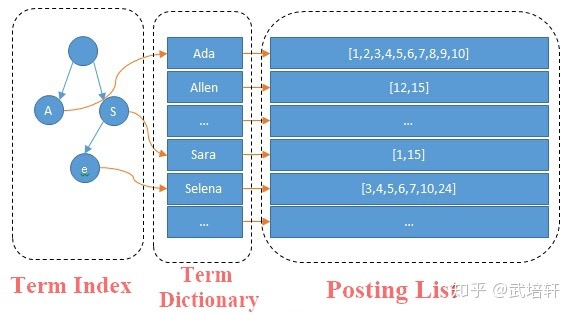

### 布尔查询  
#### 布尔查询是指利用`AND`,`OR`或者`NOT`操作符将词项连接起来的查询  
例如：`Brutus AND Caesar AND NOT Calpurnia`  
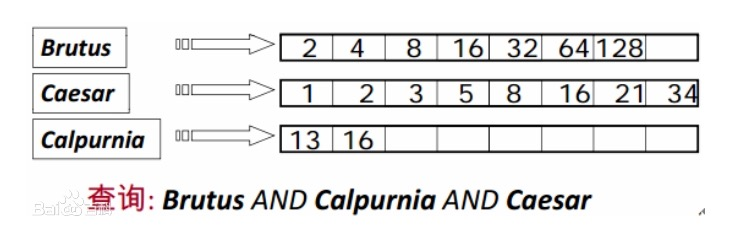  
`Posting('Brutus') ∩ Posting('Caesar') - Posting('Calpurnia')`  

In [42]:
posting_Brutus = set([2, 4, 8, 16, 64, 128])
posting_Caesar = set([1, 2, 3, 5, 8, 16, 21, 34])
posting_Calpurnia = set([13, 16])

In [43]:
posting_Brutus & posting_Caesar - posting_Calpurnia

{2, 8}

In [44]:
len(searcher.search_cache['手机'])

115

In [45]:
len(searcher.search_cache['二手'])

6

In [46]:
searcher.search_cache['手机'] & searcher.search_cache['二手']

{606, 627}

In [47]:
for did in searcher.search_cache['手机'] & searcher.search_cache['二手']:
    print(searcher.docs[did][:150] + '...')

iPhone 13出来后！闲鱼上的二手iPhone简直不要太香$$$事情的起因是这样的，每次苹果发布新款 iPhone，托尼总能注意到网上都会出现一帮网友在喊着 “ 老款 iPhone 降价，终于可以去买老款了 ” 的口号。出现这种现象的原因往往不是因为新出来的 iPhone 不香，而是要怪 iPh...
网友向罗永浩求购绝版旗舰！本人免费赠送了一台$$$近日一位网友微博求购二手坚果R1，这位网友@锤子科技CEO罗永浩：“罗哥你R1能卖我一台吗”？10月2日，作为锤子科技的年度旗舰，坚果R1创新性引入了TNT，使用扩展坞和HDMI数据线可将坚果R1手机连接至显示器，体验高效便捷的TNT大屏幕操作系统。...


#### 目标：`二手 and 手机`  ->  `Posting('二手') & Posting('手机')`  

In [49]:
eval("searcher.search_cache['手机'] & searcher.search_cache['二手']")

{606, 627}

In [50]:
def get_word_match(word):
    return searcher.search_cache[word]
eval("get_word_match('手机') & get_word_match('二手')")

{606, 627}

In [52]:
def query_to_set_expression(query):
    query_new_parts = []
    all_parts = list(query.replace('(', ' ( ').replace(')', ' ) ').split())
    idx = 0
    cache = '' #缓存变量，用于回收分词过程被切开的短语片段
    count_parts = len(all_parts)
    print(f'seg result: "{" ".join(all_parts)}"')
    while idx < count_parts:
        if all_parts[idx] == '(' or all_parts[idx] == ')':
            query_new_parts.append(all_parts[idx])
            print(f"new part: {all_parts[idx]}")
        elif all_parts[idx] == ' ' or all_parts[idx] == '':
            query_new_parts.append(' ')
            print(f"new part: ' '")
        elif all_parts[idx] in ('and', 'AND', '+'):
            query_new_parts.append('&')
            print(f"new part: '&'")
        elif all_parts[idx] in ('or', 'OR'):
            query_new_parts.append('|')
            print(f"new part: '|'")
        elif all_parts[idx] in ('not', 'NOT', '-'):
            query_new_parts.append('-')
            print(f"new part: '-'")
        else:
            if cache:
                cache += ' ' + all_parts[idx]
            else:
                cache = all_parts[idx]
                
            if (idx + 1 == count_parts
              or all_parts[idx + 1] in ('(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '')):
                query_new_parts.append(f"get_word_match('{cache}')")
                print(f"new part: get_word_match('{cache}')")
                cache = ''
        idx += 1
    query_new = ''.join(query_new_parts)
    return query_new

In [53]:
query_to_set_expression('手机 AND 二手 NOT 飞机')

seg result: "手机 AND 二手 NOT 飞机"
new part: get_word_match('手机')
new part: '&'
new part: get_word_match('二手')
new part: '-'
new part: get_word_match('飞机')


"get_word_match('手机')&get_word_match('二手')-get_word_match('飞机')"

In [54]:
eval(query_to_set_expression('手机 AND 二手 NOT 飞机'))

seg result: "手机 AND 二手 NOT 飞机"
new part: get_word_match('手机')
new part: '&'
new part: get_word_match('二手')
new part: '-'
new part: get_word_match('飞机')


{606, 627}

In [55]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle

class MySearchC4V1(MySearchC4V0):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    ----------------C4V0-----------------
    C4V1: Add basic Bool query support

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    """
    
    def query_to_set_expression(self, query):
        query_new_parts = []
        all_parts = list(query.replace('(', ' ( ').replace(')', ' ) ').split())
        idx = 0
        cache = ''
        count_parts = len(all_parts)
        while idx < count_parts:
            if all_parts[idx] == '(' or all_parts[idx] == ')':
                query_new_parts.append(all_parts[idx])
            elif all_parts[idx] == ' ' or all_parts[idx] == '':
                query_new_parts.append(' ')
            elif all_parts[idx] in ('and', 'AND', '+'):
                query_new_parts.append('&')
            elif all_parts[idx] in ('or', 'OR'):
                query_new_parts.append('|')
            elif all_parts[idx] in ('not', 'NOT', '-'):
                query_new_parts.append('-')
            else:
                if cache:
                    cache += ' ' + all_parts[idx]
                else:
                    cache = all_parts[idx]

                if (idx + 1 == count_parts
                  or all_parts[idx + 1] in ('(', ')', 'and', 'AND', '+', 'or', 'OR', 'NOT', 'not', '+', '-', ' ', '')):
                    query_new_parts.append(f"self.get_word_match('{cache}')")
                    cache = ''
            idx += 1
        query_new = ''.join(query_new_parts)
        return query_new
    
    def get_word_match(self, word):
        return self.search_cache[word]
    
    def search(self, query, num=15):
        query_lower = query.lower()    
        result_list = []
        min_score = 0
        query_new = self.query_to_set_expression(query_lower)
        for tid in eval(query_new):
            doc = self.docs_lower[tid]
            score = 1 #self.score(doc, keyword_lower)
            if len(result_list) == num:
                if score > min_score:
                    insert_idx = bisect.bisect(
                        [doc_score[1] for doc_score in result_list], 
                        score
                    )
                    min_score = result_list[0][1]
                    result_list = result_list[1:insert_idx] + \
                                    [(tid, score)] + \
                                    result_list[insert_idx:]
            elif len(result_list) < num - 1:
                result_list.append((tid, score))
            elif len(result_list) == num - 1:
                result_list.append((tid, score))
                result_list.sort(key = lambda x: x[1])
                min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]

In [56]:
searcher = MySearchC4V1('titles_l.dat', 1)

In [57]:
query = '手机 AND 二手 NOT 飞机'
search_result = searcher.search(query, num=5)
searcher.render(search_result, query)

In [58]:
query = 'iphone手机 AND 二手 NOT 飞机'
search_result = searcher.search(query, num=5)
searcher.render(search_result, query)

### 错误分析：如果布尔查询中的子段落不是词，而是短语、短句，无法直接从`search_cache`中找到对应Posting

In [59]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle

class MySearchC4V2(MySearchC4V1):
    """
    C3V0: Base class for Search Engine.
    C3V1: Data multiplication added.
    C3V2: Sorting optimization.
    C3V3: Add lowered version of docs.
    C3V4: For long doc.
    C3V5: Caching search results.
    C3V6: Pre-caching all words in docs.
    C3V7: Add Serialize/UnSerialize.
    ----------------C4V0-----------------
    C4V1: Add basic Bool query support
    C4V2: Add wordseg to get_word_match()

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    query_to_set_expression(query):
        convert bool query to set expression(for eval process).
    get_word_match(word):
        get match set of the word.
    """
    
    def get_word_match(self, word):
        if_first_subword = True
        result = None
        for term in list(jieba.cut(word)):
            if if_first_subword:
                result = self.search_cache[term]
                if_first_subword = False
            else:
                result = result & self.search_cache[term]
            if not result:
                break
        return result

In [60]:
searcher = MySearchC4V2('titles_l.dat', 1)

In [61]:
query = 'iphone手机 AND 二手 NOT 飞机'
search_result = searcher.search(query, num=5)
searcher.render(search_result, query)